In [3]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def check_annotation_status():
    """
    positive_candidatesテーブルのアノテーション状況を
    集計して表示する。
    """
    print("--- Checking Current Annotation Status in `positive_candidates` ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            
            # --- 2.1: LLMによるアノテーション状況 ---
            print("\n--- LLM Annotation Status (llm_annotation_status) ---")
            query_llm = """
                SELECT
                    CASE llm_annotation_status
                        WHEN 1 THEN 'Used'
                        WHEN -1 THEN 'Not Used'
                        WHEN 0 THEN 'Unprocessed'
                    END AS llm_status,
                    COUNT(*) AS count
                FROM
                    positive_candidates
                GROUP BY
                    llm_annotation_status;
            """
            df_llm = pd.read_sql_query(query_llm, conn)
            display(df_llm)

            # --- 2.2: 人間によるアノテーション状況 ---
            print("\n" + "="*50)
            print("--- Human Annotation Status (human_annotation_status) ---")
            query_human = """
                SELECT
                    CASE human_annotation_status
                        WHEN 1 THEN 'Human: Used'
                        WHEN -1 THEN 'Human: Not Used'
                        WHEN -2 THEN 'Human: Skipped (Data Paper)'
                        WHEN 0 THEN 'Unprocessed'
                    END AS human_status,
                    COUNT(*) AS count
                FROM
                    positive_candidates
                GROUP BY
                    human_annotation_status;
            """
            df_human = pd.read_sql_query(query_human, conn)
            display(df_human)
            
            # --- 2.3: ペア作成可能フラグの状況 ---
            print("\n" + "="*50)
            print("--- Pair-Creatable Flag Status (is_pair_creatable) ---")
            query_pair = """
                SELECT
                    CASE is_pair_creatable
                        WHEN 1 THEN 'Can create pairs (>= 2 citers)'
                        WHEN 0 THEN 'Cannot create pairs (< 2 citers)'
                    END AS pair_status,
                    COUNT(*) AS count
                FROM
                    positive_candidates
                GROUP BY
                    is_pair_creatable;
            """
            df_pair = pd.read_sql_query(query_pair, conn)
            display(df_pair)


    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
check_annotation_status()

--- Checking Current Annotation Status in `positive_candidates` ---

--- LLM Annotation Status (llm_annotation_status) ---


,llm_status,count
0,Not Used,6065
1,Unprocessed,2167
2,Used,4197



--- Human Annotation Status (human_annotation_status) ---


,human_status,count
0,Human: Skipped (Data Paper),121
1,Human: Not Used,373
2,Unprocessed,11240
3,Human: Used,695



--- Pair-Creatable Flag Status (is_pair_creatable) ---


,pair_status,count
0,Cannot create pairs (< 2 citers),2738
1,Can create pairs (>= 2 citers),9691


In [5]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def check_annotation_funnel():
    """
    positive_candidatesテーブルのアノテーション状況を
    階層的に集計して表示する。
    """
    print("--- Annotation Funnel Analysis ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            
            # --- レベル1: 全体の母集団 ---
            print("\n" + "="*50)
            print("LEVEL 1: 全正例候補（S2ORC+Scopus）")
            total_count = conn.execute("SELECT COUNT(*) FROM positive_candidates").fetchone()[0]
            print(f"  Total Candidate Pairs: {total_count:,}")

            # --- レベル2: ペア作成可能な候補 ---
            print("\n" + "="*50)
            print("LEVEL 2: ペア作成可能な候補 (is_pair_creatable = 1)")
            pair_creatable_count = conn.execute("SELECT COUNT(*) FROM positive_candidates WHERE is_pair_creatable = 1").fetchone()[0]
            print(f"  Total Pair-Creatable Candidates: {pair_creatable_count:,} / {total_count:,} ({pair_creatable_count/total_count:.2%})")

            # --- レベル3: LLMによるアノテーション状況 (レベル2の内訳) ---
            print("\n" + "="*50)
            print("LEVEL 3: LLMアノテーション状況 (in Level 2)")
            query_llm = """
                SELECT
                    CASE llm_annotation_status
                        WHEN 1 THEN 'LLM: Used'
                        WHEN -1 THEN 'LLM: Not Used'
                        WHEN 0 THEN 'LLM: Unprocessed'
                    END AS llm_status,
                    COUNT(*) AS count
                FROM
                    positive_candidates
                WHERE
                    is_pair_creatable = 1
                GROUP BY
                    llm_annotation_status;
            """
            df_llm = pd.read_sql_query(query_llm, conn)
            display(df_llm)

            # --- レベル4: 人間によるアノテーション状況 (レベル2の内訳) ---
            print("\n" + "="*50)
            print("LEVEL 4: 人間によるアノテーション状況 (in Level 2)")
            query_human = """
                SELECT
                    CASE human_annotation_status
                        WHEN 1 THEN 'Human: Used'
                        WHEN -1 THEN 'Human: Not Used'
                        WHEN -2 THEN 'Human: Skipped (Data Paper)'
                        WHEN 0 THEN 'Human: Unprocessed'
                    END AS human_status,
                    COUNT(*) AS count
                FROM
                    positive_candidates
                WHERE
                    is_pair_creatable = 1
                GROUP BY
                    human_annotation_status;
            """
            df_human = pd.read_sql_query(query_human, conn)
            display(df_human)


    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
check_annotation_funnel()

--- Annotation Funnel Analysis ---

LEVEL 1: 全正例候補（S2ORC+Scopus）
  Total Candidate Pairs: 12,429

LEVEL 2: ペア作成可能な候補 (is_pair_creatable = 1)
  Total Pair-Creatable Candidates: 9,691 / 12,429 (77.97%)

LEVEL 3: LLMアノテーション状況 (in Level 2)


,llm_status,count
0,LLM: Not Used,5706
1,LLM: Unprocessed,1
2,LLM: Used,3984



LEVEL 4: 人間によるアノテーション状況 (in Level 2)


,human_status,count
0,Human: Skipped (Data Paper),121
1,Human: Not Used,373
2,Human: Unprocessed,8504
3,Human: Used,693


In [7]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def check_detailed_annotation_funnel():
    """
    アノテーションの各階層における、引用論文数とペア数を集計して、
    詳細なファネル分析表を作成する。
    """
    print("--- Detailed Annotation Funnel Analysis ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # 必要なカラムをすべて読み込む
            df_all = pd.read_sql_query(
                "SELECT cited_datapaper_doi, citing_doi, is_pair_creatable, llm_annotation_status, human_annotation_status FROM positive_candidates", 
                conn
            )

        if df_all.empty:
            print("`positive_candidates` table is empty.")
            return

        # --- 各階層で集計 ---
        results = []

        def analyze_subset(df, level_name):
            """指定されたDataFrameのサブセットを分析する"""
            if df.empty:
                return {
                    "Level": level_name,
                    "引用論文数 (Unique)": 0,
                    "ペア数 (Total)": 0
                }
            return {
                "Level": level_name,
                "引用論文数 (Unique)": df['citing_doi'].nunique(),
                "ペア数 (Total)": len(df)
            }

        # レベル1: 全体の母集団
        df_level1 = df_all
        results.append(analyze_subset(df_level1, "Level 1: 全正例候補"))

        # レベル2: ペア作成可能な候補
        df_level2 = df_all[df_all['is_pair_creatable'] == 1]
        results.append(analyze_subset(df_level2, "Level 2: ペア作成可能 (>=2 citers)"))

        # レベル3: LLMが 'Used' と判定 (レベル2の内訳)
        df_level3 = df_level2[df_level2['llm_annotation_status'] == 1]
        results.append(analyze_subset(df_level3, "Level 3: LLM 'Used' (in Level 2)"))
        
        # レベル4: 人間が 'Used' と判定 (レベル2の内訳)
        df_level4 = df_level2[df_level2['human_annotation_status'] == 1]
        results.append(analyze_subset(df_level4, "Level 4: Human 'Used' (in Level 2)"))

        # (参考) レベル5: 人間が 'Not Used' と判定 (レベル2の内訳)
        df_level5 = df_level2[df_level2['human_annotation_status'] == -1]
        results.append(analyze_subset(df_level5, "Level 5: Human 'Not Used' (in Level 2)"))
        
        # (参考) レベル6: 人間が 'Skipped' と判定 (レベル2の内訳)
        df_level6 = df_level2[df_level2['human_annotation_status'] == -2]
        results.append(analyze_subset(df_level6, "Level 6: Human 'Skipped' (in Level 2)"))

        # --- 結果を表として表示 ---
        df_final_report = pd.DataFrame(results).set_index("Level")
        display(df_final_report)

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
check_detailed_annotation_funnel()

--- Detailed Annotation Funnel Analysis ---


,引用論文数 (Unique),ペア数 (Total)
Level,,
Level 1: 全正例候補,11249,12429
Level 2: ペア作成可能 (>=2 citers),8831,9691
Level 3: LLM 'Used' (in Level 2),3794,3984
Level 4: Human 'Used' (in Level 2),675,693
Level 5: Human 'Not Used' (in Level 2),370,373
Level 6: Human 'Skipped' (in Level 2),121,121


In [1]:
import pandas as pd
import sqlite3
import os
import plotly.graph_objects as go
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"
# 訓練用に分割されたデータ論文のリスト（150件）
TRAINING_DATAPAPERS_FILE = "../data/datapapers/sampled/training_data_papers_50.csv"

def visualize_training_distribution():
    """
    訓練用データ論文の「作成可能ペア数」を計算し、
    ツリーマップで可視化する。
    """
    print("--- Visualizing Training Set Contribution (Treemap) ---")

    if not os.path.exists(DB_PATH) or not os.path.exists(TRAINING_DATAPAPERS_FILE):
        print(f"❌ Error: Database or training data paper file not found.")
        return

    try:
        # 1. 訓練用のデータ論文リストを読み込む
        # このファイルには 'cited_datapaper_doi' と 'used_paper_count' が含まれている
        df_train = pd.read_csv(TRAINING_DATAPAPERS_FILE)
        
        # カラム名を統一
        if 'used_paper_count' not in df_train.columns and 's2orc_citing_count' in df_train.columns:
            df_train.rename(columns={'s2orc_citing_count': 'used_paper_count'}, inplace=True)

        # 2. 作成可能なペア数を計算 (k件からk-1ペア)
        # 訓練データは 'used_paper_count' >= 2 が前提
        df_train['creatable_pairs'] = df_train['used_paper_count'] - 1
        
        # 3. グラフ描画用に、どのデータ論文か判別する短いラベルを作成
        # (DOIは長すぎるため、最初の15文字とインデックスでラベルを作成)
        df_train['label'] = df_train.index.astype(str) + ": " + df_train['cited_datapaper_doi'].str.slice(0, 15) + "..."
        
        print(f"Total creatable positive pairs: {df_train['creatable_pairs'].sum():,}")

        # --- 4. ツリーマップの作成 ---
        fig = go.Figure(go.Treemap(
            labels = df_train['label'],
            parents = [""] * len(df_train), # すべてが同じ親を持つ
            values = df_train['creatable_pairs'],
            textinfo = "label+value",
            hoverinfo = "label+value+percent parent"
        ))

        fig.update_layout(
            title="訓練データセットの構成比（作成可能な正例ペア数によるツリーマップ）"
        )

        print("\n[Treemap Visualization]")
        fig.show()

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
visualize_training_distribution()

--- Visualizing Training Set Contribution (Treemap) ---
Total creatable positive pairs: 1,438

[Treemap Visualization]


--- Visualizing Training Set Annotation Progress (Matplotlib) ---

--- Annotation Status Summary Table (Top 10) ---


status_label,Human: Not Used,Human: Skipped,Human: Used,Unprocessed,Total Workload
cited_datapaper_doi,,,,,
10.1038/S41597-020-0453-3,1,0,10,168,179
10.5194/ESSD-13-4349-2021,1,0,10,72,83
10.1038/S41597-020-0534-3,1,0,10,51,62
10.1038/S41597-020-0369-Y,1,0,36,15,52
10.1038/S41597-020-0462-2,16,0,10,18,44
10.1016/J.DIB.2019.104863,7,0,37,0,44
10.1002/GDJ3.78,6,0,23,0,29
10.1038/S41597-020-0495-6,2,0,10,16,28
10.1016/J.DIB.2017.05.007,22,0,5,0,27



[Annotation Progress Chart]


C:\Users\kurokawa\AppData\Local\Temp\ipykernel_10684\133024282.py:104: UserWarning:

Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) Arial.

C:\Users\kurokawa\AppData\Local\Temp\ipykernel_10684\133024282.py:104: UserWarning:

Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) Arial.

C:\Users\kurokawa\AppData\Local\Temp\ipykernel_10684\133024282.py:104: UserWarning:

Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) Arial.

C:\Users\kurokawa\AppData\Local\Temp\ipykernel_10684\133024282.py:104: UserWarning:

Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) Arial.

C:\Users\kurokawa\AppData\Local\Temp\ipykernel_10684\133024282.py:104: UserWarning:

Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) Arial.

C:\Users\kurokawa\AppData\Local\Temp\ipykernel_10684\133024282.py:104: UserWarning:

Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) Arial.

C:\Users\kurokawa\AppData\Local\Temp\ipykernel_106

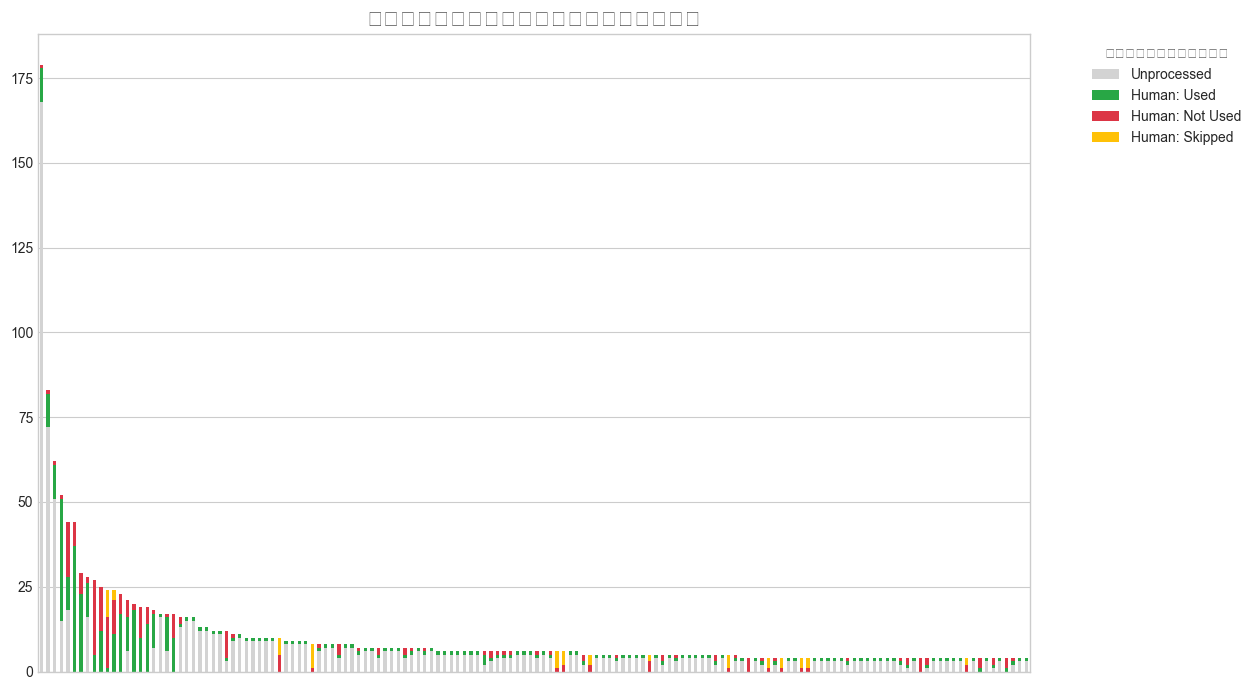

In [3]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"
# 訓練用に分割されたデータ論文のリスト（150件）
TRAINING_DATAPAPERS_FILE = "../data/datapapers/sampled/training_data_papers_50.csv"

def visualize_training_annotation_progress_mpl():
    """
    訓練用データ論文（150件）のそれぞれについて、
    アノテーションの進捗状況をmatplotlibで可視化する。
    """
    print("--- Visualizing Training Set Annotation Progress (Matplotlib) ---")

    if not os.path.exists(DB_PATH) or not os.path.exists(TRAINING_DATAPAPERS_FILE):
        print(f"❌ Error: Database or training data paper file not found.")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # 1. 訓練用のデータ論文DOIリストを取得
            df_train_papers = pd.read_csv(TRAINING_DATAPAPERS_FILE)
            train_dois = tuple(df_train_papers['cited_datapaper_doi'].unique())

            # 2. 訓練用データ論文に紐づく、LLMが'Used'と判定した候補の
            #    アノテーション状況をすべて取得
            placeholders = ','.join('?' for _ in train_dois)
            query = f"""
                SELECT
                    cited_datapaper_doi,
                    human_annotation_status
                FROM
                    positive_candidates
                WHERE
                    cited_datapaper_doi IN ({placeholders})
                    AND llm_annotation_status = 1
            """
            df_data = pd.read_sql_query(query, conn, params=train_dois)

        if df_data.empty:
            print("No 'Used' candidates found for the training set.")
            return

        # 3. データを集計するためのラベルを作成
        status_map = {
            0: 'Unprocessed',
            1: 'Human: Used',
            -1: 'Human: Not Used',
            -2: 'Human: Skipped'
        }
        df_data['status_label'] = df_data['human_annotation_status'].map(status_map)

        # 4. データ論文ごと × ステータスごとのクロス集計表を作成
        df_summary = pd.crosstab(df_data['cited_datapaper_doi'], df_data['status_label'])
        
        # グラフの表示順を定義
        status_order = ['Unprocessed', 'Human: Used', 'Human: Not Used', 'Human: Skipped']
        
        # 欠損している列（例: まだ'Used'が1件もない）を0で埋める
        for label in status_order:
            if label not in df_summary.columns:
                df_summary[label] = 0
        
        # Totalでソートし、表示に必要な列のみを正しい順番で選択
        df_summary['Total Workload'] = df_summary.sum(axis=1)
        df_plot = df_summary.sort_values(by='Total Workload', ascending=False)[status_order]
        
        print("\n--- Annotation Status Summary Table (Top 10) ---")
        display(df_summary.sort_values(by='Total Workload', ascending=False).head(10))

        # --- 5. 積み上げ棒グラフの作成 (matplotlib) ---
        plt.style.use('seaborn-v0_8-whitegrid')
        
        # 色を定義
        colors = {
            'Unprocessed': '#D3D3D3',     # 薄いグレー
            'Human: Used': '#28a745',      # 緑
            'Human: Not Used': '#dc3545', # 赤
            'Human: Skipped': '#ffc107'   # 黄
        }
        
        # pandasのDataFrame.plot機能を使って積み上げ棒グラフを作成
        ax = df_plot.plot(
            kind='bar', 
            stacked=True, 
            figsize=(15, 7),
            color=[colors[col] for col in df_plot.columns]
        )
        
        # --- グラフの修飾 ---
        ax.set_title('訓練用データ論文のアノテーション進捗状況', fontsize=16)
        
        # ▼▼▼ ご要望の修正点 ▼▼▼
        ax.set_ylabel('') # Y軸のラベルを削除
        ax.set_xlabel('') # X軸のラベルを削除
        ax.set_xticks([]) # X軸の目盛り（DOI）を削除
        
        ax.legend(title='人間による判定ステータス', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # 凡例がグラフに被らないように調整
        
        print("\n[Annotation Progress Chart]")
        plt.show()

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
visualize_training_annotation_progress_mpl()

In [4]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"
# 訓練用に分割されたデータ論文のリスト（150件）
TRAINING_DATAPAPERS_FILE = "../data/datapapers/sampled/training_data_papers_50.csv"

def analyze_top_group_pairs():
    """
    訓練用データセットの中で、最もアノテーション対象が多い
    データ論文グループを1件特定し、作成可能なペア数を計算する。
    """
    print("--- Analyzing Pair Potential of the Largest Training Group ---")

    if not os.path.exists(DB_PATH) or not os.path.exists(TRAINING_DATAPAPERS_FILE):
        print(f"❌ Error: Database or training data paper file not found.")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # 1. 訓練用のデータ論文DOIリストを取得
            df_train_papers = pd.read_csv(TRAINING_DATAPAPERS_FILE)
            train_dois = tuple(df_train_papers['cited_datapaper_doi'].unique())

            # 2. 訓練用データ論文について、アノテーション状況を集計
            placeholders = ','.join('?' for _ in train_dois)
            query_stats = f"""
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS total_llm_used, -- LLMがUsedと判定した総数
                    SUM(CASE WHEN human_annotation_status = 1 THEN 1 ELSE 0 END) AS k_green, -- 人間がUsed (緑)
                    SUM(CASE WHEN human_annotation_status = 0 THEN 1 ELSE 0 END) AS k_white -- 未処理 (白)
                FROM
                    positive_candidates
                WHERE
                    cited_datapaper_doi IN ({placeholders})
                    AND llm_annotation_status = 1
                GROUP BY
                    cited_datapaper_doi;
            """
            df_stats = pd.read_sql_query(query_stats, conn, params=train_dois)

        if df_stats.empty:
            print("No 'Used' candidates found for the training set.")
            return

        # 3. 最も作業量が多い（LLMがUsedと判定した総数が最大）グループを特定
        top_group = df_stats.nlargest(1, 'total_llm_used').iloc[0]

        k_green = top_group['k_green']
        k_white = top_group['k_white']

        # 4. ペア数を計算 (順序は区別しない)
        
        # (緑, 緑) ペア数 = k_green C 2 = k_green * (k_green - 1) / 2
        # すでに人間が確認した論文同士で作成できるペア
        pairs_gg = k_green * (k_green - 1) // 2 
        
        # (緑, 白) ペア数 = k_green * k_white
        # すでに確認した論文と、まだ未処理の論文との間で作成できるペア
        pairs_gw = k_green * k_white

        # --- 5. 結果の報告 ---
        print("\n" + "="*50)
        print("--- Analysis for the Largest Group ---")
        print(f"Data Paper DOI: {top_group['cited_datapaper_doi']}")
        print(f"LLMが 'Used' と判定した候補論文の総数: {top_group['total_llm_used']:,}")
        print("-" * 50)
        print(f"緑の数 (人間が 'Used' と確認): {k_green:,}")
        print(f"白の数 (LLM 'Used' / 人間が未処理): {k_white:,}")
        print("="*50)
        print("--- Potential Pair Combinations ---")
        print(f"(緑, 緑) ペアの組み合わせ数: {pairs_gg:,}")
        print(f"(緑, 白) ペアの組み合わせ数: {pairs_gw:,}")
        print("-" * 50)
        print(f"現在作成可能な総ペア数 (緑, 緑): {pairs_gg:,}")
        print(f"未処理分のアノテーションで追加されるペア数 (緑, 白): {pairs_gw:,}")
        print(f"  (注: 白がすべて緑と判定された場合の最大値)")

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_top_group_pairs()

--- Analyzing Pair Potential of the Largest Training Group ---

--- Analysis for the Largest Group ---
Data Paper DOI: 10.1038/S41597-020-0453-3
LLMが 'Used' と判定した候補論文の総数: 179
--------------------------------------------------
緑の数 (人間が 'Used' と確認): 10
白の数 (LLM 'Used' / 人間が未処理): 168
--- Potential Pair Combinations ---
(緑, 緑) ペアの組み合わせ数: 45
(緑, 白) ペアの組み合わせ数: 1,680
--------------------------------------------------
現在作成可能な総ペア数 (緑, 緑): 45
未処理分のアノテーションで追加されるペア数 (緑, 白): 1,680
  (注: 白がすべて緑と判定された場合の最大値)


In [5]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"
# 訓練用に分割されたデータ論文のリスト（150件）
TRAINING_DATAPAPERS_FILE = "../data/datapapers/sampled/training_data_papers_50.csv"

def summarize_all_group_pairs():
    """
    訓練用データ論文（150件）のそれぞれについて、
    (緑, 緑)ペア数、(緑, 白)ペア数を計算し、一覧表と総数を表示する。
    """
    print("--- Summarizing Pair Combinations for All Training Groups ---")

    if not os.path.exists(DB_PATH) or not os.path.exists(TRAINING_DATAPAPERS_FILE):
        print(f"❌ Error: Database or training data paper file not found.")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # 1. 訓練用のデータ論文DOIリストを取得
            df_train_papers = pd.read_csv(TRAINING_DATAPAPERS_FILE)
            train_dois = tuple(df_train_papers['cited_datapaper_doi'].unique())

            # 2. 訓練用データ論文に紐づく、LLMが'Used'と判定した候補の
            #    アノテーション状況を集計
            placeholders = ','.join('?' for _ in train_dois)
            query_stats = f"""
                SELECT
                    cited_datapaper_doi,
                    SUM(CASE WHEN human_annotation_status = 1 THEN 1 ELSE 0 END) AS k_green, -- 人間がUsed (緑)
                    SUM(CASE WHEN human_annotation_status = 0 THEN 1 ELSE 0 END) AS k_white -- 未処理 (白)
                FROM
                    positive_candidates
                WHERE
                    cited_datapaper_doi IN ({placeholders})
                    AND llm_annotation_status = 1
                GROUP BY
                    cited_datapaper_doi;
            """
            df_stats = pd.read_sql_query(query_stats, conn, params=train_dois)

        if df_stats.empty:
            print("No 'Used' candidates found for the training set.")
            return

        # 3. ペア数を計算 (順序は区別しない)
        # (緑, 緑) ペア数 = k_green C 2 = k_green * (k_green - 1) / 2
        df_stats['pairs_green_green'] = df_stats['k_green'].apply(lambda x: x * (x - 1) // 2)
        
        # (緑, 白) ペア数 = k_green * k_white
        df_stats['pairs_green_white'] = df_stats['k_green'] * df_stats['k_white']

        # 合計ペア数
        df_stats['total_potential_pairs'] = df_stats['pairs_green_green'] + df_stats['pairs_green_white']

        # 4. 結果を表として表示
        # わかりやすいようにカラム名を変更
        df_stats = df_stats.rename(columns={
            'k_green': 'Human_Used_Count',
            'k_white': 'Unprocessed_Count'
        })

        # 表示順を調整
        display_cols = [
            'cited_datapaper_doi', 
            'Human_Used_Count', 
            'Unprocessed_Count', 
            'pairs_green_green', 
            'pairs_green_white', 
            'total_potential_pairs'
        ]
        
        # 'total_potential_pairs'で降順にソートして表示
        df_display = df_stats[display_cols].sort_values(by='total_potential_pairs', ascending=False)
        
        print("\n--- Pair Combinations by Data Paper Group ---")
        display(df_display)

        # 5. 総数の表示
        print("\n" + "="*50)
        print("--- Grand Totals ---")
        print(f"総 (緑, 緑) ペア数 (現在確定): {df_display['pairs_green_green'].sum():,}")
        print(f"総 (緑, 白) ペア数 (アノテーションで追加可能): {df_display['pairs_green_white'].sum():,}")
        print(f"総ポテンシャルペア数 (最大): {df_display['total_potential_pairs'].sum():,}")
        print("="*50)

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
summarize_all_group_pairs()

--- Summarizing Pair Combinations for All Training Groups ---

--- Pair Combinations by Data Paper Group ---


,cited_datapaper_doi,Human_Used_Count,Unprocessed_Count,pairs_green_green,pairs_green_white,total_potential_pairs
102,10.1038/S41597-020-0453-3,10,168,45,1680,1725
93,10.1038/S41597-020-0369-Y,36,15,630,540,1170
145,10.5194/ESSD-13-4349-2021,10,72,45,720,765
27,10.1016/J.DIB.2019.104863,37,0,666,0,666
110,10.1038/S41597-020-0534-3,10,51,45,510,555
...,...,...,...,...,...,...
95,10.1038/S41597-020-0395-9,0,0,0,0,0
115,10.1038/S41597-021-00815-Z,0,0,0,0,0
127,10.1038/S41597-022-01288-4,0,0,0,0,0
133,10.1038/S41597-022-01514-Z,1,0,0,0,0



--- Grand Totals ---
総 (緑, 緑) ペア数 (現在確定): 2,513
総 (緑, 白) ペア数 (アノテーションで追加可能): 4,550
総ポテンシャルペア数 (最大): 7,063
